# 필요 라이브러리 import

In [122]:
import os
from pprint import pprint
from PIL import Image
from matplotlib.pyplot import imshow
import random
import re
from tqdm import tqdm
import cv2
import numpy as np
import json
import pandas as pd
import annoy
from annoy import AnnoyIndex
import pickle
import random

In [ ]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision

# 학습 이미지 데이터 경로

In [124]:
cropped_dir='./data/fashion_data/cropped/'

# Model Design : Metric Learning with PyTorch

## 모델 정의

In [ ]:
device = torch.device("cuda")

In [127]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(9216, 128)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         return x

def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in tqdm(enumerate(train_loader)):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        with open(f'loss_data{epoch}.txt', 'w', encoding='utf-8') as f:
            if batch_idx % 20 == 0:
                print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))
                data = "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets)
                f.write(data)

### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model) # 살림
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class DeepFashionImageDataset(Dataset):
    def __init__(self, img_dir, transform=None): # new_item_list를 추가해봄
    #img_dir : crop한 이미지가 있는 경로
        self.img_dir = img_dir
        self.transform = transform
        self.img_list = os.listdir(img_dir)
        self.label_code = []

        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.img_list[idx]))
        label = self.img_list[idx].split('_')[3:5]
        label = '_'.join(label)
        
        if label not in self.label_code:
            self.label_code.append(label)
        code = self.label_code.index(label)

        if self.transform:
            img = self.transform(img)

        return img, code

dataset = DeepFashionImageDataset(cropped_dir, transform=transform)
length = int(len(dataset)*0.8)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [length, len(dataset)-length])

cuda


## 학습 진행

In [10]:
PATH = './model_save/'
current_epoch = 0
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
if len(os.listdir(PATH)) > 0:
    model_name = sorted(os.listdir(PATH))[-1]
    model = torch.load(os.path.join(PATH, model_name)).to(device)
    current_epoch = int(model_name.replace('_', '.').split('.')[-2])
    network = model
else:
    network = models.resnet18(pretrained=True).to(device)

In [13]:
print(network)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

# ### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)
# ### pytorch-metric-learning stuff ###


for epoch in range(current_epoch+1, num_epochs+1):
    train(network, loss_func, mining_func, device, train_loader, optimizer, epoch)
    torch.save(model, PATH + f'k_fashion_category_color_{epoch:04d}.pt')

0it [00:00, ?it/s]C:\Users\JAY\anaconda3\envs\torch_p38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
1it [00:03,  3.37s/it]

Epoch 1 Iteration 0: Loss = 0.10934017598628998, Number of mined triplets = 9449


21it [00:18,  1.29it/s]

Epoch 1 Iteration 20: Loss = 0.14757905900478363, Number of mined triplets = 2265


41it [00:33,  1.26it/s]

Epoch 1 Iteration 40: Loss = 0.12471646070480347, Number of mined triplets = 7183


61it [00:48,  1.29it/s]

Epoch 1 Iteration 60: Loss = 0.12674377858638763, Number of mined triplets = 5275


81it [01:02,  1.30it/s]

Epoch 1 Iteration 80: Loss = 0.11471996456384659, Number of mined triplets = 4345


101it [01:17,  1.31it/s]

Epoch 1 Iteration 100: Loss = 0.12179340422153473, Number of mined triplets = 3758


121it [01:32,  1.30it/s]

Epoch 1 Iteration 120: Loss = 0.12199343740940094, Number of mined triplets = 3542


141it [01:47,  1.23it/s]

Epoch 1 Iteration 140: Loss = 0.1215161383152008, Number of mined triplets = 3614


161it [02:01,  1.28it/s]

Epoch 1 Iteration 160: Loss = 0.12041094154119492, Number of mined triplets = 3506


181it [02:17,  1.26it/s]

Epoch 1 Iteration 180: Loss = 0.11467664688825607, Number of mined triplets = 3278


201it [02:32,  1.26it/s]

Epoch 1 Iteration 200: Loss = 0.12104952335357666, Number of mined triplets = 5220


221it [02:47,  1.28it/s]

Epoch 1 Iteration 220: Loss = 0.13443244993686676, Number of mined triplets = 5500


241it [03:02,  1.27it/s]

Epoch 1 Iteration 240: Loss = 0.1152447760105133, Number of mined triplets = 4002


261it [03:17,  1.31it/s]

Epoch 1 Iteration 260: Loss = 0.11495054513216019, Number of mined triplets = 5089


281it [03:32,  1.25it/s]

Epoch 1 Iteration 280: Loss = 0.10881320387125015, Number of mined triplets = 2898


301it [03:47,  1.28it/s]

Epoch 1 Iteration 300: Loss = 0.11020462960004807, Number of mined triplets = 3565


321it [04:01,  1.30it/s]

Epoch 1 Iteration 320: Loss = 0.11643075197935104, Number of mined triplets = 4062


341it [04:16,  1.22it/s]

Epoch 1 Iteration 340: Loss = 0.11746277660131454, Number of mined triplets = 3625


361it [04:31,  1.25it/s]

Epoch 1 Iteration 360: Loss = 0.1206117570400238, Number of mined triplets = 2950


381it [04:47,  1.28it/s]

Epoch 1 Iteration 380: Loss = 0.10740204155445099, Number of mined triplets = 3216


401it [05:02,  1.22it/s]

Epoch 1 Iteration 400: Loss = 0.10300546884536743, Number of mined triplets = 3706


421it [05:17,  1.25it/s]

Epoch 1 Iteration 420: Loss = 0.10410452634096146, Number of mined triplets = 5702


441it [05:32,  1.24it/s]

Epoch 1 Iteration 440: Loss = 0.10682044923305511, Number of mined triplets = 3165


461it [05:48,  1.23it/s]

Epoch 1 Iteration 460: Loss = 0.1098119243979454, Number of mined triplets = 3906


481it [06:03,  1.24it/s]

Epoch 1 Iteration 480: Loss = 0.11029931157827377, Number of mined triplets = 2893


501it [06:18,  1.18it/s]

Epoch 1 Iteration 500: Loss = 0.12391196936368942, Number of mined triplets = 3670


521it [06:33,  1.24it/s]

Epoch 1 Iteration 520: Loss = 0.11554888635873795, Number of mined triplets = 4729


541it [06:48,  1.22it/s]

Epoch 1 Iteration 540: Loss = 0.1030975952744484, Number of mined triplets = 5394


561it [07:03,  1.27it/s]

Epoch 1 Iteration 560: Loss = 0.1094878762960434, Number of mined triplets = 3140


581it [07:18,  1.23it/s]

Epoch 1 Iteration 580: Loss = 0.11825008690357208, Number of mined triplets = 3487


601it [07:34,  1.25it/s]

Epoch 1 Iteration 600: Loss = 0.10436548292636871, Number of mined triplets = 3203


621it [07:49,  1.24it/s]

Epoch 1 Iteration 620: Loss = 0.10466831177473068, Number of mined triplets = 4664


641it [08:04,  1.21it/s]

Epoch 1 Iteration 640: Loss = 0.10023012012243271, Number of mined triplets = 4868


661it [08:19,  1.27it/s]

Epoch 1 Iteration 660: Loss = 0.10922059416770935, Number of mined triplets = 3963


681it [08:34,  1.23it/s]

Epoch 1 Iteration 680: Loss = 0.10511836409568787, Number of mined triplets = 3499


701it [08:49,  1.27it/s]

Epoch 1 Iteration 700: Loss = 0.10653230547904968, Number of mined triplets = 5175


721it [09:04,  1.26it/s]

Epoch 1 Iteration 720: Loss = 0.10642849653959274, Number of mined triplets = 3670


741it [09:19,  1.26it/s]

Epoch 1 Iteration 740: Loss = 0.11322542279958725, Number of mined triplets = 2600


761it [09:35,  1.22it/s]

Epoch 1 Iteration 760: Loss = 0.10268726944923401, Number of mined triplets = 3967


781it [09:50,  1.22it/s]

Epoch 1 Iteration 780: Loss = 0.10597176104784012, Number of mined triplets = 3621


801it [10:05,  1.26it/s]

Epoch 1 Iteration 800: Loss = 0.10864251106977463, Number of mined triplets = 3865


821it [10:21,  1.25it/s]

Epoch 1 Iteration 820: Loss = 0.10962746292352676, Number of mined triplets = 3840


841it [10:36,  1.22it/s]

Epoch 1 Iteration 840: Loss = 0.11214626580476761, Number of mined triplets = 2956


861it [10:51,  1.26it/s]

Epoch 1 Iteration 860: Loss = 0.10654551535844803, Number of mined triplets = 3594


881it [11:06,  1.22it/s]

Epoch 1 Iteration 880: Loss = 0.11029241979122162, Number of mined triplets = 4412


901it [11:22,  1.22it/s]

Epoch 1 Iteration 900: Loss = 0.10117620974779129, Number of mined triplets = 3968


921it [11:38,  1.19it/s]

Epoch 1 Iteration 920: Loss = 0.10250521451234818, Number of mined triplets = 4493


941it [11:53,  1.24it/s]

Epoch 1 Iteration 940: Loss = 0.10287976264953613, Number of mined triplets = 5581


961it [12:08,  1.25it/s]

Epoch 1 Iteration 960: Loss = 0.1091470867395401, Number of mined triplets = 5648


981it [12:23,  1.26it/s]

Epoch 1 Iteration 980: Loss = 0.09461764246225357, Number of mined triplets = 5161


1001it [12:38,  1.23it/s]

Epoch 1 Iteration 1000: Loss = 0.10041375458240509, Number of mined triplets = 3302


1021it [12:54,  1.19it/s]

Epoch 1 Iteration 1020: Loss = 0.10935571789741516, Number of mined triplets = 3730


1041it [13:09,  1.24it/s]

Epoch 1 Iteration 1040: Loss = 0.10618055611848831, Number of mined triplets = 3627


1061it [13:25,  1.19it/s]

Epoch 1 Iteration 1060: Loss = 0.10573150962591171, Number of mined triplets = 2786


1081it [13:40,  1.22it/s]

Epoch 1 Iteration 1080: Loss = 0.10534118115901947, Number of mined triplets = 4155


1101it [13:56,  1.18it/s]

Epoch 1 Iteration 1100: Loss = 0.1049739420413971, Number of mined triplets = 3021


1121it [14:11,  1.30it/s]

Epoch 1 Iteration 1120: Loss = 0.10598123073577881, Number of mined triplets = 3029


1141it [14:27,  1.20it/s]

Epoch 1 Iteration 1140: Loss = 0.10063621401786804, Number of mined triplets = 4937


1161it [14:43,  1.09it/s]

Epoch 1 Iteration 1160: Loss = 0.10521063953638077, Number of mined triplets = 2933


1181it [14:59,  1.23it/s]

Epoch 1 Iteration 1180: Loss = 0.11090581864118576, Number of mined triplets = 3271


1201it [15:15,  1.26it/s]

Epoch 1 Iteration 1200: Loss = 0.10564218461513519, Number of mined triplets = 2916


1221it [15:30,  1.27it/s]

Epoch 1 Iteration 1220: Loss = 0.10796982049942017, Number of mined triplets = 5425


1241it [15:45,  1.25it/s]

Epoch 1 Iteration 1240: Loss = 0.1055426225066185, Number of mined triplets = 4388


1261it [16:00,  1.21it/s]

Epoch 1 Iteration 1260: Loss = 0.10348758846521378, Number of mined triplets = 2051


1281it [16:16,  1.21it/s]

Epoch 1 Iteration 1280: Loss = 0.10862795263528824, Number of mined triplets = 2304


1301it [16:31,  1.25it/s]

Epoch 1 Iteration 1300: Loss = 0.11863460391759872, Number of mined triplets = 2441


1321it [16:46,  1.25it/s]

Epoch 1 Iteration 1320: Loss = 0.10970010608434677, Number of mined triplets = 3359


1341it [17:02,  1.18it/s]

Epoch 1 Iteration 1340: Loss = 0.10279469192028046, Number of mined triplets = 4794


1361it [17:17,  1.24it/s]

Epoch 1 Iteration 1360: Loss = 0.10857786983251572, Number of mined triplets = 4271


1381it [17:33,  1.17it/s]

Epoch 1 Iteration 1380: Loss = 0.10261878371238708, Number of mined triplets = 3534


1401it [17:48,  1.23it/s]

Epoch 1 Iteration 1400: Loss = 0.09337402880191803, Number of mined triplets = 2495


1421it [18:03,  1.23it/s]

Epoch 1 Iteration 1420: Loss = 0.11316947638988495, Number of mined triplets = 2745


1441it [18:18,  1.21it/s]

Epoch 1 Iteration 1440: Loss = 0.10102426260709763, Number of mined triplets = 5272


1461it [18:34,  1.19it/s]

Epoch 1 Iteration 1460: Loss = 0.09694153815507889, Number of mined triplets = 4669


1481it [18:50,  1.19it/s]

Epoch 1 Iteration 1480: Loss = 0.09997246414422989, Number of mined triplets = 4582


1501it [19:06,  1.24it/s]

Epoch 1 Iteration 1500: Loss = 0.10027828067541122, Number of mined triplets = 4469


1521it [19:21,  1.17it/s]

Epoch 1 Iteration 1520: Loss = 0.10076894611120224, Number of mined triplets = 3615


1541it [19:36,  1.26it/s]

Epoch 1 Iteration 1540: Loss = 0.10681093484163284, Number of mined triplets = 4211


1561it [19:52,  1.26it/s]

Epoch 1 Iteration 1560: Loss = 0.10006676614284515, Number of mined triplets = 5187


1581it [20:07,  1.24it/s]

Epoch 1 Iteration 1580: Loss = 0.1035865843296051, Number of mined triplets = 2687


1601it [20:22,  1.23it/s]

Epoch 1 Iteration 1600: Loss = 0.1169159859418869, Number of mined triplets = 2191


1621it [20:38,  1.13it/s]

Epoch 1 Iteration 1620: Loss = 0.10247623175382614, Number of mined triplets = 3600


1641it [20:54,  1.21it/s]

Epoch 1 Iteration 1640: Loss = 0.11106935143470764, Number of mined triplets = 3841


1661it [21:09,  1.20it/s]

Epoch 1 Iteration 1660: Loss = 0.10128697752952576, Number of mined triplets = 3630


1681it [21:25,  1.22it/s]

Epoch 1 Iteration 1680: Loss = 0.10257396101951599, Number of mined triplets = 2986


1701it [21:40,  1.20it/s]

Epoch 1 Iteration 1700: Loss = 0.10428998619318008, Number of mined triplets = 5310


1721it [21:56,  1.21it/s]

Epoch 1 Iteration 1720: Loss = 0.11093634366989136, Number of mined triplets = 3041


1741it [22:11,  1.21it/s]

Epoch 1 Iteration 1740: Loss = 0.10782616585493088, Number of mined triplets = 2909


1761it [22:27,  1.22it/s]

Epoch 1 Iteration 1760: Loss = 0.10139930248260498, Number of mined triplets = 3520


1781it [22:43,  1.23it/s]

Epoch 1 Iteration 1780: Loss = 0.09917201101779938, Number of mined triplets = 4630


1801it [22:58,  1.23it/s]

Epoch 1 Iteration 1800: Loss = 0.10188774764537811, Number of mined triplets = 3196


1821it [23:14,  1.22it/s]

Epoch 1 Iteration 1820: Loss = 0.10060646384954453, Number of mined triplets = 3280


1841it [23:30,  1.18it/s]

Epoch 1 Iteration 1840: Loss = 0.09940173476934433, Number of mined triplets = 4841


1861it [23:45,  1.19it/s]

Epoch 1 Iteration 1860: Loss = 0.10638715326786041, Number of mined triplets = 2900


1881it [24:01,  1.20it/s]

Epoch 1 Iteration 1880: Loss = 0.09694892913103104, Number of mined triplets = 3991


1901it [24:17,  1.20it/s]

Epoch 1 Iteration 1900: Loss = 0.106318898499012, Number of mined triplets = 4470


1921it [24:33,  1.22it/s]

Epoch 1 Iteration 1920: Loss = 0.10835392773151398, Number of mined triplets = 3237


1941it [24:49,  1.20it/s]

Epoch 1 Iteration 1940: Loss = 0.10555432736873627, Number of mined triplets = 3467


1961it [25:04,  1.20it/s]

Epoch 1 Iteration 1960: Loss = 0.10666298866271973, Number of mined triplets = 2756


1981it [25:20,  1.22it/s]

Epoch 1 Iteration 1980: Loss = 0.10281394422054291, Number of mined triplets = 5519


2001it [25:35,  1.19it/s]

Epoch 1 Iteration 2000: Loss = 0.09788516163825989, Number of mined triplets = 2654


2021it [25:51,  1.20it/s]

Epoch 1 Iteration 2020: Loss = 0.09802263975143433, Number of mined triplets = 3517


2041it [26:07,  1.20it/s]

Epoch 1 Iteration 2040: Loss = 0.10583055764436722, Number of mined triplets = 4169


2061it [26:23,  1.22it/s]

Epoch 1 Iteration 2060: Loss = 0.11123453825712204, Number of mined triplets = 2880


2081it [26:39,  1.21it/s]

Epoch 1 Iteration 2080: Loss = 0.10828812420368195, Number of mined triplets = 5298


2101it [26:54,  1.21it/s]

Epoch 1 Iteration 2100: Loss = 0.10431360453367233, Number of mined triplets = 4007


2121it [27:10,  1.22it/s]

Epoch 1 Iteration 2120: Loss = 0.10163026303052902, Number of mined triplets = 4199


2141it [27:26,  1.20it/s]

Epoch 1 Iteration 2140: Loss = 0.0963861271739006, Number of mined triplets = 4317


2161it [27:41,  1.19it/s]

Epoch 1 Iteration 2160: Loss = 0.1084737777709961, Number of mined triplets = 2376


2181it [27:57,  1.20it/s]

Epoch 1 Iteration 2180: Loss = 0.10390292853116989, Number of mined triplets = 3324


2201it [28:13,  1.22it/s]

Epoch 1 Iteration 2200: Loss = 0.10389859974384308, Number of mined triplets = 3010


2221it [28:29,  1.20it/s]

Epoch 1 Iteration 2220: Loss = 0.09706265479326248, Number of mined triplets = 4688


2241it [28:44,  1.23it/s]

Epoch 1 Iteration 2240: Loss = 0.09716270864009857, Number of mined triplets = 4268


2261it [29:00,  1.21it/s]

Epoch 1 Iteration 2260: Loss = 0.0995846688747406, Number of mined triplets = 3646


2281it [29:16,  1.21it/s]

Epoch 1 Iteration 2280: Loss = 0.09857230633497238, Number of mined triplets = 1902


2301it [29:32,  1.17it/s]

Epoch 1 Iteration 2300: Loss = 0.10183775424957275, Number of mined triplets = 3986


2321it [29:48,  1.18it/s]

Epoch 1 Iteration 2320: Loss = 0.10058721899986267, Number of mined triplets = 3157


2341it [30:04,  1.22it/s]

Epoch 1 Iteration 2340: Loss = 0.12141425162553787, Number of mined triplets = 2370


2361it [30:19,  1.23it/s]

Epoch 1 Iteration 2360: Loss = 0.0985022708773613, Number of mined triplets = 2657


2381it [30:35,  1.23it/s]

Epoch 1 Iteration 2380: Loss = 0.11305798590183258, Number of mined triplets = 4193


2401it [30:51,  1.20it/s]

Epoch 1 Iteration 2400: Loss = 0.10477133095264435, Number of mined triplets = 2469


2421it [31:07,  1.22it/s]

Epoch 1 Iteration 2420: Loss = 0.10231848061084747, Number of mined triplets = 3981


2441it [31:22,  1.21it/s]

Epoch 1 Iteration 2440: Loss = 0.1110706627368927, Number of mined triplets = 5084


2461it [31:38,  1.18it/s]

Epoch 1 Iteration 2460: Loss = 0.1105315238237381, Number of mined triplets = 2627


2481it [31:54,  1.19it/s]

Epoch 1 Iteration 2480: Loss = 0.10115133225917816, Number of mined triplets = 2005


2501it [32:09,  1.21it/s]

Epoch 1 Iteration 2500: Loss = 0.11126280575990677, Number of mined triplets = 2275


2521it [32:25,  1.19it/s]

Epoch 1 Iteration 2520: Loss = 0.10549549758434296, Number of mined triplets = 3333


2541it [32:42,  1.14it/s]

Epoch 1 Iteration 2540: Loss = 0.10166318714618683, Number of mined triplets = 3691


2561it [32:58,  1.19it/s]

Epoch 1 Iteration 2560: Loss = 0.1008564829826355, Number of mined triplets = 3473


2581it [33:13,  1.20it/s]

Epoch 1 Iteration 2580: Loss = 0.10421688854694366, Number of mined triplets = 2713


2601it [33:29,  1.17it/s]

Epoch 1 Iteration 2600: Loss = 0.10615115612745285, Number of mined triplets = 3141


2621it [33:45,  1.15it/s]

Epoch 1 Iteration 2620: Loss = 0.10335151106119156, Number of mined triplets = 3255


2641it [34:01,  1.17it/s]

Epoch 1 Iteration 2640: Loss = 0.09788895398378372, Number of mined triplets = 3369


2661it [34:17,  1.20it/s]

Epoch 1 Iteration 2660: Loss = 0.10252054035663605, Number of mined triplets = 4592


2681it [34:33,  1.20it/s]

Epoch 1 Iteration 2680: Loss = 0.10778667032718658, Number of mined triplets = 3359


2701it [34:49,  1.19it/s]

Epoch 1 Iteration 2700: Loss = 0.10907381772994995, Number of mined triplets = 3981


2721it [35:05,  1.17it/s]

Epoch 1 Iteration 2720: Loss = 0.10190858691930771, Number of mined triplets = 3758


2741it [35:21,  1.20it/s]

Epoch 1 Iteration 2740: Loss = 0.10104554891586304, Number of mined triplets = 2625


2761it [35:36,  1.19it/s]

Epoch 1 Iteration 2760: Loss = 0.10777419805526733, Number of mined triplets = 5098


2781it [35:52,  1.19it/s]

Epoch 1 Iteration 2780: Loss = 0.10114066302776337, Number of mined triplets = 2119


2801it [36:08,  1.23it/s]

Epoch 1 Iteration 2800: Loss = 0.10360202938318253, Number of mined triplets = 3880


2821it [36:24,  1.22it/s]

Epoch 1 Iteration 2820: Loss = 0.10496339201927185, Number of mined triplets = 3927


2841it [36:39,  1.21it/s]

Epoch 1 Iteration 2840: Loss = 0.09702476859092712, Number of mined triplets = 2936


2861it [36:55,  1.20it/s]

Epoch 1 Iteration 2860: Loss = 0.10920579731464386, Number of mined triplets = 3737


2881it [37:11,  1.18it/s]

Epoch 1 Iteration 2880: Loss = 0.1125955879688263, Number of mined triplets = 3196


2901it [37:27,  1.16it/s]

Epoch 1 Iteration 2900: Loss = 0.11633407324552536, Number of mined triplets = 3359


2921it [37:43,  1.21it/s]

Epoch 1 Iteration 2920: Loss = 0.11408419162034988, Number of mined triplets = 3649


2941it [37:59,  1.20it/s]

Epoch 1 Iteration 2940: Loss = 0.10258529335260391, Number of mined triplets = 3067


2961it [38:15,  1.19it/s]

Epoch 1 Iteration 2960: Loss = 0.0976291298866272, Number of mined triplets = 4011


2981it [38:31,  1.19it/s]

Epoch 1 Iteration 2980: Loss = 0.10251780599355698, Number of mined triplets = 2880


3001it [38:47,  1.18it/s]

Epoch 1 Iteration 3000: Loss = 0.11110872775316238, Number of mined triplets = 3690


3021it [39:02,  1.20it/s]

Epoch 1 Iteration 3020: Loss = 0.09791228175163269, Number of mined triplets = 3178


3041it [39:18,  1.20it/s]

Epoch 1 Iteration 3040: Loss = 0.11307685077190399, Number of mined triplets = 5156


3061it [39:34,  1.21it/s]

Epoch 1 Iteration 3060: Loss = 0.09922332316637039, Number of mined triplets = 2503


3081it [39:50,  1.19it/s]

Epoch 1 Iteration 3080: Loss = 0.09796255826950073, Number of mined triplets = 2531


3101it [40:06,  1.21it/s]

Epoch 1 Iteration 3100: Loss = 0.09439757466316223, Number of mined triplets = 4615


3121it [40:22,  1.20it/s]

Epoch 1 Iteration 3120: Loss = 0.10081023722887039, Number of mined triplets = 5141


3141it [40:38,  1.18it/s]

Epoch 1 Iteration 3140: Loss = 0.10127972811460495, Number of mined triplets = 3581


3161it [40:54,  1.18it/s]

Epoch 1 Iteration 3160: Loss = 0.10445605963468552, Number of mined triplets = 4641


3181it [41:09,  1.20it/s]

Epoch 1 Iteration 3180: Loss = 0.10645424574613571, Number of mined triplets = 4677


3201it [41:25,  1.22it/s]

Epoch 1 Iteration 3200: Loss = 0.1014803871512413, Number of mined triplets = 3776


3221it [41:41,  1.18it/s]

Epoch 1 Iteration 3220: Loss = 0.10428906977176666, Number of mined triplets = 6243


3241it [41:56,  1.20it/s]

Epoch 1 Iteration 3240: Loss = 0.0972355306148529, Number of mined triplets = 4755


3261it [42:12,  1.22it/s]

Epoch 1 Iteration 3260: Loss = 0.10086065530776978, Number of mined triplets = 2958


3281it [42:28,  1.18it/s]

Epoch 1 Iteration 3280: Loss = 0.11976493149995804, Number of mined triplets = 3773


3301it [42:44,  1.20it/s]

Epoch 1 Iteration 3300: Loss = 0.10543130338191986, Number of mined triplets = 2722


3321it [42:59,  1.19it/s]

Epoch 1 Iteration 3320: Loss = 0.10386160761117935, Number of mined triplets = 4972


3341it [43:15,  1.17it/s]

Epoch 1 Iteration 3340: Loss = 0.09820012003183365, Number of mined triplets = 3960


3361it [43:31,  1.21it/s]

Epoch 1 Iteration 3360: Loss = 0.11192333698272705, Number of mined triplets = 4297


3381it [43:47,  1.19it/s]

Epoch 1 Iteration 3380: Loss = 0.10451261699199677, Number of mined triplets = 3510


3401it [44:03,  1.15it/s]

Epoch 1 Iteration 3400: Loss = 0.10944322496652603, Number of mined triplets = 2437


3421it [44:18,  1.22it/s]

Epoch 1 Iteration 3420: Loss = 0.10598774254322052, Number of mined triplets = 4029


3441it [44:34,  1.23it/s]

Epoch 1 Iteration 3440: Loss = 0.10534463822841644, Number of mined triplets = 3578


3461it [44:50,  1.21it/s]

Epoch 1 Iteration 3460: Loss = 0.10676658898591995, Number of mined triplets = 5946


3481it [45:06,  1.19it/s]

Epoch 1 Iteration 3480: Loss = 0.11046245694160461, Number of mined triplets = 4375


3501it [45:21,  1.18it/s]

Epoch 1 Iteration 3500: Loss = 0.13356079161167145, Number of mined triplets = 7106


3521it [45:37,  1.21it/s]

Epoch 1 Iteration 3520: Loss = 0.11002528667449951, Number of mined triplets = 4187


3541it [45:53,  1.20it/s]

Epoch 1 Iteration 3540: Loss = 0.10147760808467865, Number of mined triplets = 3475


3561it [46:09,  1.20it/s]

Epoch 1 Iteration 3560: Loss = 0.09704378247261047, Number of mined triplets = 4212


3581it [46:25,  1.19it/s]

Epoch 1 Iteration 3580: Loss = 0.10818284749984741, Number of mined triplets = 3982


3601it [46:41,  1.18it/s]

Epoch 1 Iteration 3600: Loss = 0.10513091832399368, Number of mined triplets = 2967


3621it [46:57,  1.17it/s]

Epoch 1 Iteration 3620: Loss = 0.09561921656131744, Number of mined triplets = 5441


3641it [47:13,  1.21it/s]

Epoch 1 Iteration 3640: Loss = 0.11055480688810349, Number of mined triplets = 3368


3661it [47:29,  1.22it/s]

Epoch 1 Iteration 3660: Loss = 0.11201143264770508, Number of mined triplets = 2741


3681it [47:44,  1.21it/s]

Epoch 1 Iteration 3680: Loss = 0.09942418336868286, Number of mined triplets = 3651


3701it [48:00,  1.21it/s]

Epoch 1 Iteration 3700: Loss = 0.09965521842241287, Number of mined triplets = 2057


3721it [48:16,  1.23it/s]

Epoch 1 Iteration 3720: Loss = 0.10413317382335663, Number of mined triplets = 3845


3741it [48:32,  1.21it/s]

Epoch 1 Iteration 3740: Loss = 0.09913206845521927, Number of mined triplets = 4023


3761it [48:47,  1.17it/s]

Epoch 1 Iteration 3760: Loss = 0.09805432707071304, Number of mined triplets = 3289


3781it [49:03,  1.20it/s]

Epoch 1 Iteration 3780: Loss = 0.09898798912763596, Number of mined triplets = 4812


3801it [49:19,  1.20it/s]

Epoch 1 Iteration 3800: Loss = 0.10722603648900986, Number of mined triplets = 2491


3821it [49:35,  1.19it/s]

Epoch 1 Iteration 3820: Loss = 0.1064152792096138, Number of mined triplets = 3638


3841it [49:51,  1.21it/s]

Epoch 1 Iteration 3840: Loss = 0.10261603444814682, Number of mined triplets = 2416


3861it [50:06,  1.21it/s]

Epoch 1 Iteration 3860: Loss = 0.09601105749607086, Number of mined triplets = 2996


3881it [50:22,  1.18it/s]

Epoch 1 Iteration 3880: Loss = 0.10411786288022995, Number of mined triplets = 2767


3901it [50:38,  1.18it/s]

Epoch 1 Iteration 3900: Loss = 0.10134665668010712, Number of mined triplets = 2411


3921it [50:54,  1.20it/s]

Epoch 1 Iteration 3920: Loss = 0.10836304724216461, Number of mined triplets = 2966


3941it [51:10,  1.20it/s]

Epoch 1 Iteration 3940: Loss = 0.09597659856081009, Number of mined triplets = 3111


3961it [51:26,  1.20it/s]

Epoch 1 Iteration 3960: Loss = 0.10327475517988205, Number of mined triplets = 2902


3981it [51:42,  1.21it/s]

Epoch 1 Iteration 3980: Loss = 0.10023929923772812, Number of mined triplets = 2537


4001it [51:58,  1.20it/s]

Epoch 1 Iteration 4000: Loss = 0.10567048192024231, Number of mined triplets = 4617


4021it [52:14,  1.20it/s]

Epoch 1 Iteration 4020: Loss = 0.1058511734008789, Number of mined triplets = 2566


4041it [52:30,  1.18it/s]

Epoch 1 Iteration 4040: Loss = 0.10082260519266129, Number of mined triplets = 4296


4061it [52:46,  1.21it/s]

Epoch 1 Iteration 4060: Loss = 0.1003943458199501, Number of mined triplets = 3573


4077it [52:58,  1.28it/s]
C:\Users\JAY\anaconda3\envs\torch_p38\lib\site-packages\torch\utils\data\dataloader.py:478: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/16307 [00:00<?, ?it/s]

# Test 진행

In [128]:
# model
PATH = './model_save/'
print(sorted(os.listdir(PATH))[-1])
network = torch.load(os.path.join(PATH, sorted(os.listdir(PATH))[-1])).to(device)

k_fashion_category_color_0018.pt


In [129]:
network.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [130]:
def get_img(path):
    input_image = Image.open(path)
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0).to(device)
    return input_batch

def get_feature_vector(img):
    with torch.no_grad():
        feature_vector = network(img)
    return feature_vector

def calculate_similarity(vector1, vector2):
    return 1-cosine(vector1, vector2)

In [12]:
# 인스타 pickle and annoy 파일 생성
insta_dir = '../clothes_recommendation_service_project/data/image/insta_image'
f = 1000
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
insta_index = {k:v for k, v in enumerate(os.listdir(insta_dir))}
with open('./resnet_pickle_annoy/insta_index_epoch18.pickle', 'wb') as f:
    pickle.dump(insta_index, f, pickle.HIGHEST_PROTOCOL)

# resnet_pickle_annoy
for no, fn in tqdm(insta_index.items()):
    img = get_img(f'{insta_dir}/{fn}')
#     img = cv2.imread('{}/{}'.format(insta_dir,fn))
    v = get_feature_vector(img)[0]
    t.add_item(no, v)

t.build(10) # 10 trees
t.save('./resnet_pickle_annoy/insta_search_epoch18.ann') # insta 검색용

  0%|          | 0/6138 [00:00<?, ?it/s]C:\Users\JAY\anaconda3\envs\torch_p38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 6138/6138 [04:38<00:00, 22.01it/s]


True

In [13]:
# 무신사 pickle and annoy 파일 생성
mu_dir = '../clothes_recommendation_service_project/data/image/mall_image'
f = 1000
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
mu_index = {k:v for k, v in enumerate(os.listdir(mu_dir))}
with open('./resnet_pickle_annoy/mu_index_epoch18.pickle', 'wb') as f:
    pickle.dump(mu_index, f, pickle.HIGHEST_PROTOCOL)

for no, fn in tqdm(mu_index.items()):
    try:
        img = get_img(f'{mu_dir}/{fn}')
        v = get_feature_vector(img)[0]
        t.add_item(no, v)
    except:
        continue
t.build(10) # 10 trees
t.save('./resnet_pickle_annoy/mu_search_epoch18.ann') # musinsa 검색용

100%|██████████| 89930/89930 [59:16<00:00, 25.28it/s]  


True

In [14]:
# 운영체제 호환을 위한 convert from pickle to json 
# 인스타
# open pickle file
path = './resnet_pickle_annoy/insta_index_epoch18.pickle'
with open(path, 'rb') as infile:
    obj = pickle.load(infile)

# convert pickle object to json object
json_obj = json.loads(json.dumps(obj, default=str))

# write the json file
with open(os.path.splitext(path)[0] + '.json', 'w', encoding='utf-8') as outfile:
    json.dump(json_obj, outfile, ensure_ascii=False, indent=4)

In [15]:
# 운영체제 호환을 위한 convert from pickle to json 
# 무신사
# open pickle file
path = './resnet_pickle_annoy/mu_index_epoch18.pickle'
with open(path, 'rb') as infile:
    obj = pickle.load(infile)

# convert pickle object to json object
json_obj = json.loads(json.dumps(obj, default=str))

# write the json file
with open(os.path.splitext(path)[0] + '.json', 'w', encoding='utf-8') as outfile:
    json.dump(json_obj, outfile, ensure_ascii=False, indent=4)

In [132]:
with open('./resnet_pickle_annoy/mu_index_epoch18.json','r') as f:
    mu_index = json.load(f)
mu_search = AnnoyIndex(1000, 'angular')
mu_search.load('./resnet_pickle_annoy/mu_search_epoch18.ann')

with open('./resnet_pickle_annoy/insta_index_epoch18.json','r') as f:
    insta_index = json.load(f)
insta_revers_index = {v:k for k , v in insta_index.items()}
insta_search = AnnoyIndex(1000, 'angular')
insta_search.load('./resnet_pickle_annoy/insta_search_epoch18.ann')

True

In [212]:
def match_mu(q): #파일 이름으로 검색하고 찾는다.
    result = mu_search.get_nns_by_vector(q, 5, include_distances=True)
    result = list(zip(result[0], result[1]))
    result = [('{}'.format(mu_index[str(no)]), score) for no, score in result]
    return result

def match_insta(fn): #파일 이름으로 검색하고 찾는다.
    img = get_img(fn)
    q = get_feature_vector(img)[0]
    result = insta_search.get_nns_by_vector(q, 5, include_distances=True)
    result = list(zip(result[0], result[1]))
    result = [('{}'.format(insta_index[str(no)]), score) for no, score in result]
    return result

# 인스타 아이템 항목에 대한 페어(상의-하의 / 하의-상의 리스트)
insta_pair = pd.read_csv('../clothes_recommendation_service_project/flask_v2/model/insta_pair.csv')

def match_pair(fn) :
    print(fn)
    fn_dir, fn_name = os.path.split(fn)
    new_name = fn_name.split('_')[0] + '_' + fn_name.split('_')[1] + '_' + fn_name.split('_')[2]  # 0815수정
    file_names = insta_pair.loc[insta_pair['image_name'].str.contains(new_name),"image_name"].values
    file_names = list(file_names)
    if fn_name in file_names:
        file_names.remove(fn_name)
    filenames = np.array(file_names)
    
    pair_keys=[insta_revers_index[v] for v in file_names]
    result = [(insta_search.get_item_vector(int(v)), 1) for v in pair_keys]
    return result

def search_pair(target) :
    result = match_insta(target)
    matched = False

    for i in range(len(result)):
        temp = match_pair(result[i][0])
        if temp != None:
            result = temp
            matched = True
            break

    if not matched:
        result = [] 
    r=[]
    
    for i in range(len(result)) :
        temp = match_mu(result[i][0])
        for j in range(len(temp)):
            r.append(temp[j])

    return r

def search_similar(target) :
    img = get_img(target)
    q = get_feature_vector(img)[0]
    temp = match_mu(q)
    return temp

image_13686_p0_b1_c0.jpg


In [213]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# 한글폰트 깨짐 방지
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin':
    rc('font', family='binggrae')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/binggrae.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system!!')

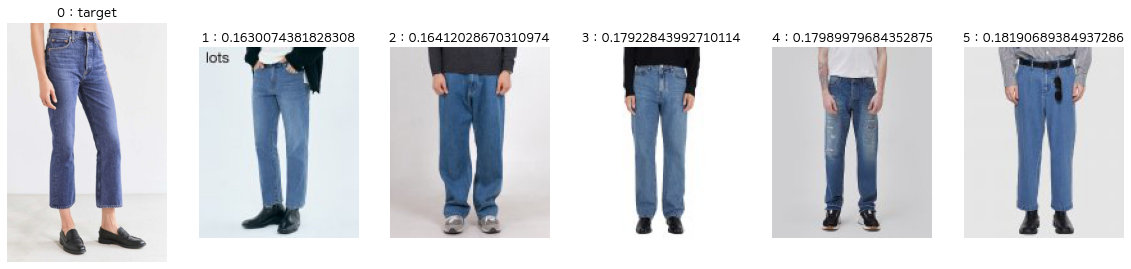

In [220]:
# 검색기에 넣을 옷
target = '../clothes_recommendation_service_project/img/test_image4.jpg'
# target = '../clothes_recommendation_service_project/img/pants.jpg'
# 유사한 옷 찾기
similarites = search_similar(target)

# 유사 옷 시각화
path = '../clothes_recommendation_service_project/data/image/mall_image/'
target_tuple = (target, 'target')
ls = []
for name, score in similarites:
    ls.append((path+name, score))
visualization_ls = [target_tuple] + ls

visualization_ls
cnt = 0
figure, axs = plt.subplots(figsize=(20,10), nrows=1, ncols=6)
# target에 대한 무신사 옷 추천 1~5'
for name, score in visualization_ls:
    img = Image.open(name)
    axs[cnt].imshow(img)
    axs[cnt].axis('off')
    axs[cnt].set_title(f'{cnt} : {score}')
    cnt+=1

plt.show()

image_08133_p0_b0_c7.jpg


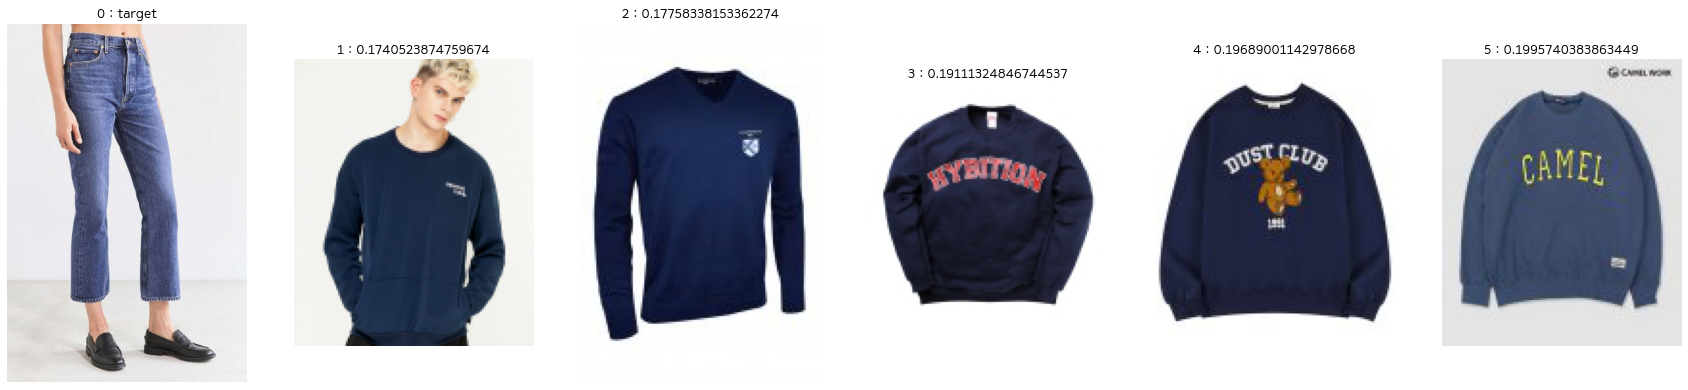

In [221]:
pair = search_pair(target)

# 페어 시각화
path = '../clothes_recommendation_service_project/data/image/mall_image/'
target_tuple = (target, 'target')
ls = []
for name, score in pair:
    ls.append((path+name, score))
visualization_ls = [target_tuple] + ls

visualization_ls
cnt = 0
figure, axs = plt.subplots(figsize=(30,10), nrows=1, ncols=6)
# figure, axs = plt.subplots(figsize=(30,10), nrows=1, ncols=11)
# target에 대한 무신사 옷 추천 1~5'
for name, score in visualization_ls:
    img = Image.open(name)
    axs[cnt].imshow(img)
    axs[cnt].axis('off')
    axs[cnt].set_title(f'{cnt} : {score}')
    cnt+=1

plt.show()

In [60]:
network = torch.load('./triple_model/k_fashion_category_color_0009.pt')
network.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# Embedding projector를 위한 tsv 파일 생성
test_data = [os.path.join(cropped_dir, x) for x in os.listdir(cropped_dir)]

f1 = open('./em/k_fashion_epoch18.tsv', 'w', encoding='utf-8')
f2 = open('./em/metadata_k_fashion_epoch18.tsv', 'w', encoding='utf-8')
random.seed(100)
test_data1 = random.sample(test_data, 50000)

for img_file in tqdm(test_data1):
    img = Image.open(img_file)
    img = transform(img)
    img = img.unsqueeze(0).to(device)
    output = network(img).to('cpu')
    row = output.detach().numpy()[0]
    label = os.path.basename(img_file).split('_')[3:5]
    label = '_'.join(label)
    f1.write('\t'.join([f'{d}' for d in row])+'\n')
    f2.write(f'{label}\n')

f1.close()
f2.close()

100%|██████████| 50000/50000 [09:28<00:00, 87.99it/s] 
